In [1]:
%load_ext autoreload
%autoreload 2

**INSTALLATION ISSUES**

There are lots of linking issues that occur if you have qt installed via Conda. I figured it out by uninstalling Qt and reinstalling the affected packages through `pip`. The reason is that CoppeliaSim needs a *very specific* version of `pip` in order to function.

Additionally, I found that my code would crash due to being "unable to load plugin 'xcb' even though it was found". To fix this, people [have found](https://github.com/NVlabs/instant-ngp/discussions/300) that you can set `QT_QPA_PLUGIN=offscreen` as an environment variable. This seemed to work for me, and it what causes the kernel to die when using Jupyter without a desktop allocation on Rivanna.


In [2]:
import os

# We do this because of the reasoning described above.
os.environ['QT_QPA_PLUGIN'] = 'offscreen'

In [3]:
"""
Approach: Similar to RVT.
Generate "virtual views" of a scene. Train a diffusion model to generate future keypoints or grasps with natural language guidance.
Will use a combination of CLIP and Segment Anything features.

Hopefully, should be amenable to massive multi-task learning with high accuracy, using only visual data.

Step 1. Dataset: Samples from RLBench. We will initially only use position, but quickly adopt towards rotation as well.

A case for ``simple" state space diffusion.

"""

# import cv2
import matplotlib.pyplot as plt
import torch

import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import JointVelocity
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.tasks import OpenDrawer
from rlbench.observation_config import ObservationConfig

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# from voxel_renderer import VoxelRenderer

# Get some observations
env = Environment(
    MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
    '/scratch/gsk6me/RLBench_Data/train',
    obs_config=ObservationConfig(),
    headless=True)
env.launch()

task = env.get_task(OpenDrawer)

print("Getting demos...")
demos = task.get_demos(8, live_demos=False)

env.shutdown()


/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Getting demos...


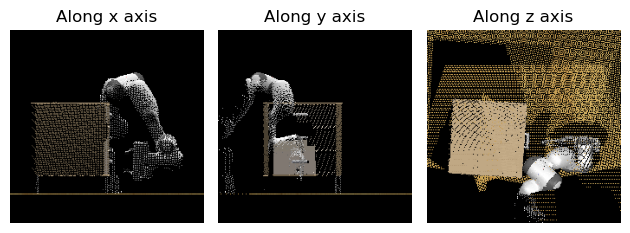

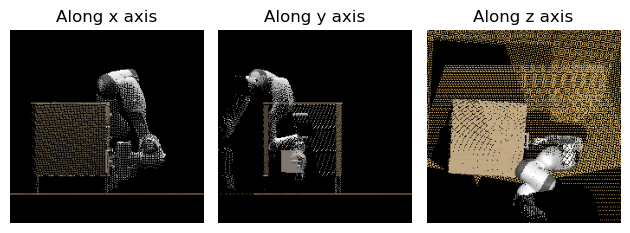

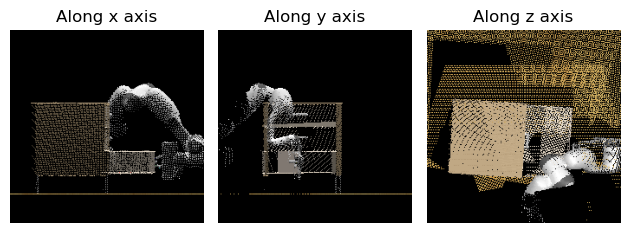

In [13]:
from voxel_renderer_slow import VoxelRenderer
from keypoint_generation import get_keypoint_observation_indexes
import cv2

device = 'cuda'

SCENE_BOUNDS = [
    -0.3,
    -0.5,
    0.6,
    0.7,
    0.5,
    1.6,
]
VOXEL_IMAGE_SIZE = 224
BACKGROUND_COLOR = torch.tensor([0, 0, 0], device=device)

renderer = VoxelRenderer(SCENE_BOUNDS, VOXEL_IMAGE_SIZE, BACKGROUND_COLOR, device=device)

demo = demos[0]

for index in get_keypoint_observation_indexes(demo):
    obs = demo[index]

    pcds = []
    colors = []
    
    cameras = [
        'front',
        'left_shoulder',
        'right_shoulder',
        'wrist',
    ]
    
    for camera in cameras:
        pcds.append(
            torch.tensor(getattr(obs, camera + '_point_cloud').reshape(-1, 3))
        )
        colors.append(
            torch.tensor(getattr(obs, camera + '_rgb').reshape(-1, 3) / 255.0)
        )
    
    pcd = torch.cat(pcds).to(device)
    color = torch.cat(colors).to(device)
    
    images = renderer(pcd, color)
    
    plt.clf()
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title("Along " + ('xyz'[i]) + " axis")
        # Blur the image slightly
        image = (images[i].cpu().numpy()).astype(np.float32)
        # image = cv2.medianBlur(image, 5)
        plt.imshow(image, origin='lower')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Test with Gaussian splats

These images don't look that great because of the sparseness of the point clouds.


In [ ]:
from voxel_renderer import get_cube_perspective_rasterizer
from pytorch3d.renderer import PointsRenderer, AlphaCompositor

img_size = 224
radius = 8
device = "cuda"
renderer = PointsRenderer(
    rasterizer=get_cube_perspective_rasterizer(img_size, radius, device),
    # Used to determine how points get aggregated.
    # Could alternatively be a norm-weighted compositor.
    compositor=AlphaCompositor()
)

renderer(Pointclouds(points=points, features=features))